In [54]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.spatial.distance import pdist,cdist, squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score
import random
import umap
from sklearn.decomposition import KernelPCA

SEED = 4
random.seed(SEED)

# loading the 50-dimensional PCA of the PBMC3k dataset - our ground dataset
adata = sc.datasets.pbmc3k_processed()
X = adata.obsm["X_pca"]
print(X.shape)

(2638, 50)


In [55]:
### creating the impostor
n = int(len(X))
C = 20000000
D_squared = cdist(X,X, metric='sqeuclidean')
D_squared_impostor = D_squared + C*(np.ones((n,n)) - np.eye(n)) 
D_squared_impostor /= np.max(D_squared_impostor)
H = np.eye(n) - np.ones((n,n)) / n

X_impostor = KernelPCA(n_components=n-1, kernel='precomputed', random_state=SEED).fit_transform( - H @ D_squared_impostor @ H / 2.0 )

In [56]:
actual_dist_matrix = cdist(X_impostor, X_impostor, metric='sqeuclidean')

err = np.sum( (actual_dist_matrix - D_squared_impostor)**2 )
err = err /  np.sum(D_squared_impostor**2)


print('error incurred by kernel PCA is quite small:', err   )

error incurred by kernel PCA is quite small: 1.8620009108232796e-30


In [57]:
### run t-SNE and PCA on the impostor and the original dataset

pca = PCA(n_components=2, random_state=SEED)
tsne = TSNE(n_components=2, random_state=SEED)

X_pca = pca.fit_transform(X) # pca(X, noise_scale=0.01)#
X_tsne = tsne.fit_transform(X)

X_pca_impostor =  pca.fit_transform(X_impostor) #pca(X_impostor, noise_scale=0.01)
X_tsne_impostor = tsne.fit_transform(X_impostor)

In [58]:
## getting the DBSCAN clustering based on the t-SNE plot, using this as our reference labelling
db = DBSCAN(eps=5, min_samples=50).fit(X_tsne)
labels = db.labels_  # cluster labels, -1 means noise

order = np.argsort(labels)
X_reordered = X[order]
X_impostor_reordered = X_impostor[order]

In [59]:
orig_ss = silhouette_score(X, labels)
blownup_ss = silhouette_score(X_impostor, labels)

tsne_ss = silhouette_score(X_tsne, labels)
tsne_blownup_ss = silhouette_score(X_tsne_impostor, labels)

pca_ss = silhouette_score(X_pca, labels)
pca_blownup_ss = silhouette_score(X_pca_impostor, labels)

print('Silhouette of DBSCAN on original \t\t\t', orig_ss)
print('Silhouette of DBSCAN on transformed \t\t\t',blownup_ss)
print()
print('Silhouette of DBSCAN on t-sne \t\t\t\t', tsne_ss)
print('Silhouette of DBSCAN on t-sne of trx \t\t\t', tsne_blownup_ss)
print()
print('Silhouette of DBSCAN on pca \t\t\t\t', pca_ss)
print('Silhouette of DBSCAN on pca of trx \t\t\t', pca_blownup_ss)

Silhouette of DBSCAN on original 			 0.17723818
Silhouette of DBSCAN on transformed 			 2.912358928542258e-06

Silhouette of DBSCAN on t-sne 				 0.6738397
Silhouette of DBSCAN on t-sne of trx 			 0.7345826

Silhouette of DBSCAN on pca 				 0.522232
Silhouette of DBSCAN on pca of trx 			 -0.009434369851597655


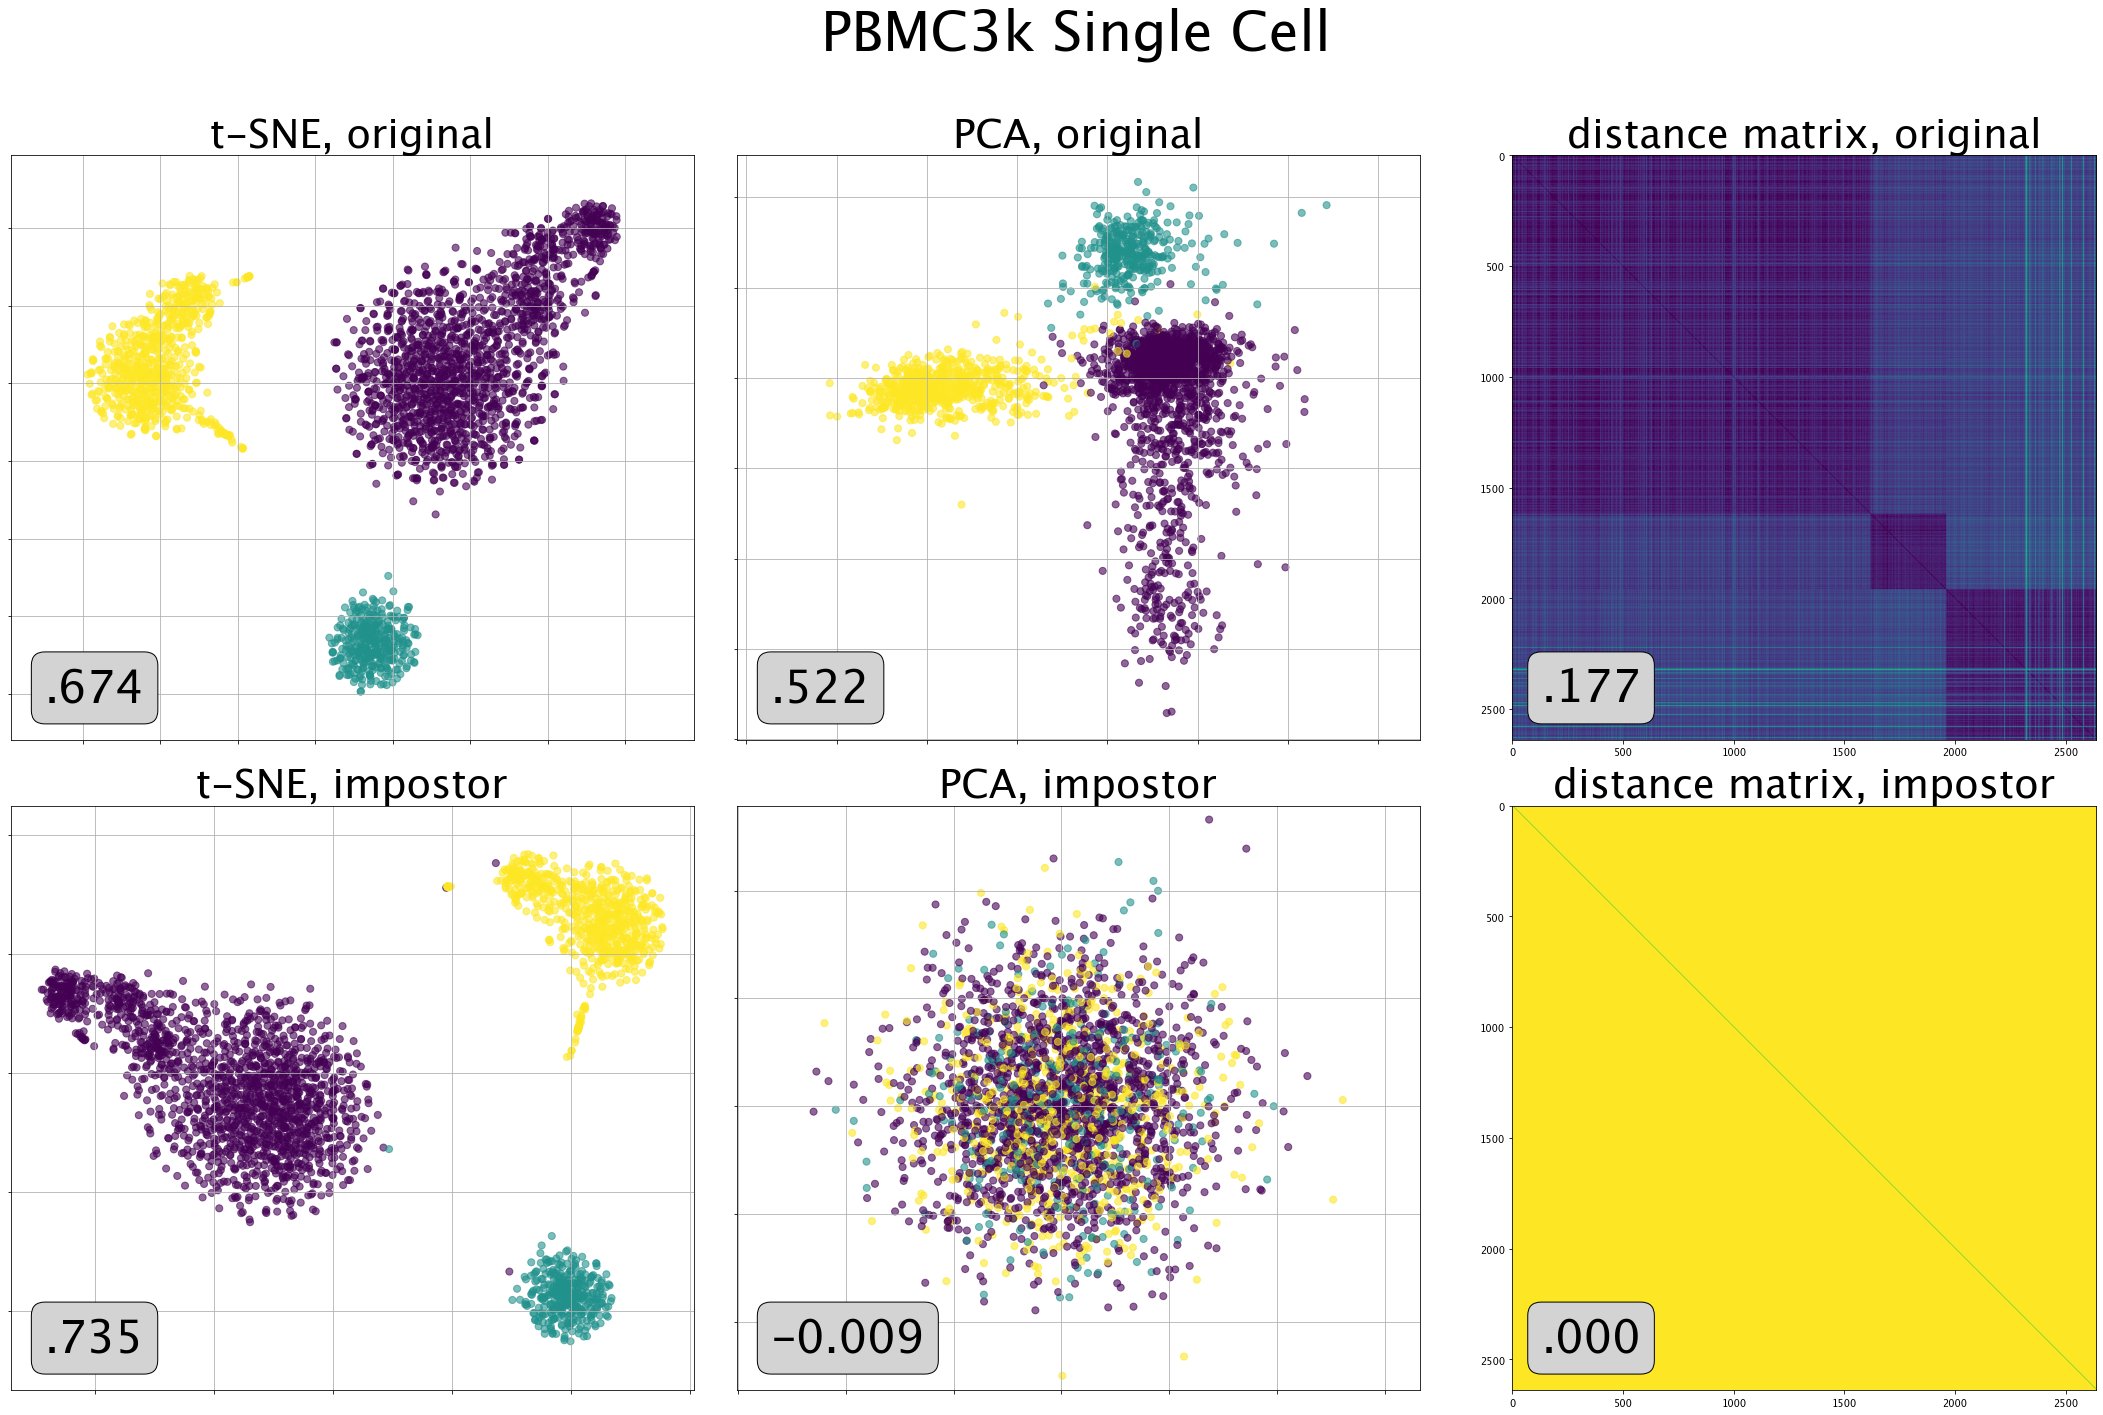

In [60]:
fig, axs = plt.subplots(2,3, figsize=(30,20))

#cmap = mcolors.ListedColormap(["purple", "green", "blue"])

for i in range(2):
    for j in range(2):
        axs[i,j].grid('on')
        axs[i,j].axis('equal')
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])

axs[0,0].text(0.05, 0.05, f"{tsne_ss:.3f}".lstrip("0"),transform=axs[0,0].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[0,0].set_title('t-SNE, original', fontsize=40)
axs[0,0].scatter(-X_tsne[:, 0], X_tsne[:, 1], s=50, alpha=0.6,  c=labels)#, cmap=cmap)

axs[0,2].text(0.05, 0.05, f"{orig_ss:.3f}".lstrip("0"), transform=axs[0,2].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[0,2].set_title('distance matrix, original', fontsize=40)
axs[0,2].imshow(cdist(X_reordered, X_reordered, metric='euclidean'), vmin=13,vmax=50)

axs[0,1].text(0.05, 0.05, f"{pca_ss:.3f}".lstrip("0"),transform=axs[0,1].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[0,1].set_title('PCA, original', fontsize=40)
axs[0,1].scatter(-X_pca[:, 0], -X_pca[:, 1], s=50, alpha=0.6,  c=labels)#, cmap=cmap)



axs[1,0].text(0.05, 0.05, f"{tsne_blownup_ss:.3f}".lstrip("0"), transform=axs[1,0].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[1,0].set_title('t-SNE, impostor', fontsize=40)
axs[1,0].scatter(X_tsne_impostor[:, 0], X_tsne_impostor[:, 1], s=50, alpha=0.6,  c=labels)#, cmap=cmap)

axs[1,2].text(0.05, 0.05, f"{blownup_ss:.3f}".lstrip("0"),transform=axs[1,2].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[1,2].set_title('distance matrix, impostor', fontsize=40)
axs[1,2].imshow(cdist(X_impostor_reordered, X_impostor_reordered, metric='euclidean') ) #, vmin=vmin, vmax=vmax)

axs[1,1].text(0.05, 0.05, f"{pca_blownup_ss:.3f}".lstrip("0"), transform=axs[1,1].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=45, ha="left", va="bottom")
axs[1,1].set_title('PCA, impostor', fontsize=40)
axs[1,1].scatter(X_pca_impostor[:, 0], X_pca_impostor[:, 1], s=50, alpha=0.6,  c=labels)#, cmap=cmap)

fig.suptitle('PBMC3k Single Cell\n', fontsize=55)

plt.tight_layout()
plt.savefig('visuals/1_single_cell/single_cell_main_figure.png', bbox_inches='tight')

In [61]:
from tqdm import tqdm
print('PCA performance on different runs')
X_pcas = []
X_tsnes = []

Cs = [10**4, 10**5, 10**6, 10**7, 10**8]

for i in tqdm(range(5)):

    D_squared = cdist(X,X, metric='sqeuclidean')
    D_squared_impostor = D_squared + Cs[i]*(np.ones((n,n)) - np.eye(n)) 
    D_squared_impostor /= np.max(D_squared_impostor)
    H = np.eye(n) - np.ones((n,n)) / n
    X_impostor_ = KernelPCA(n_components=n-1, kernel='precomputed', random_state=SEED).fit_transform( - H @ D_squared_impostor @ H / 2.0 )


    X_pca_ = pca.fit_transform(X_impostor_)
    X_pcas.append(X_pca_)
    X_tsne_ = tsne.fit_transform(X_impostor_)
    X_tsnes.append(X_tsne_)


PCA performance on different runs


100%|██████████| 5/5 [01:50<00:00, 22.14s/it]


100%|██████████| 5/5 [00:00<00:00, 217.55it/s]


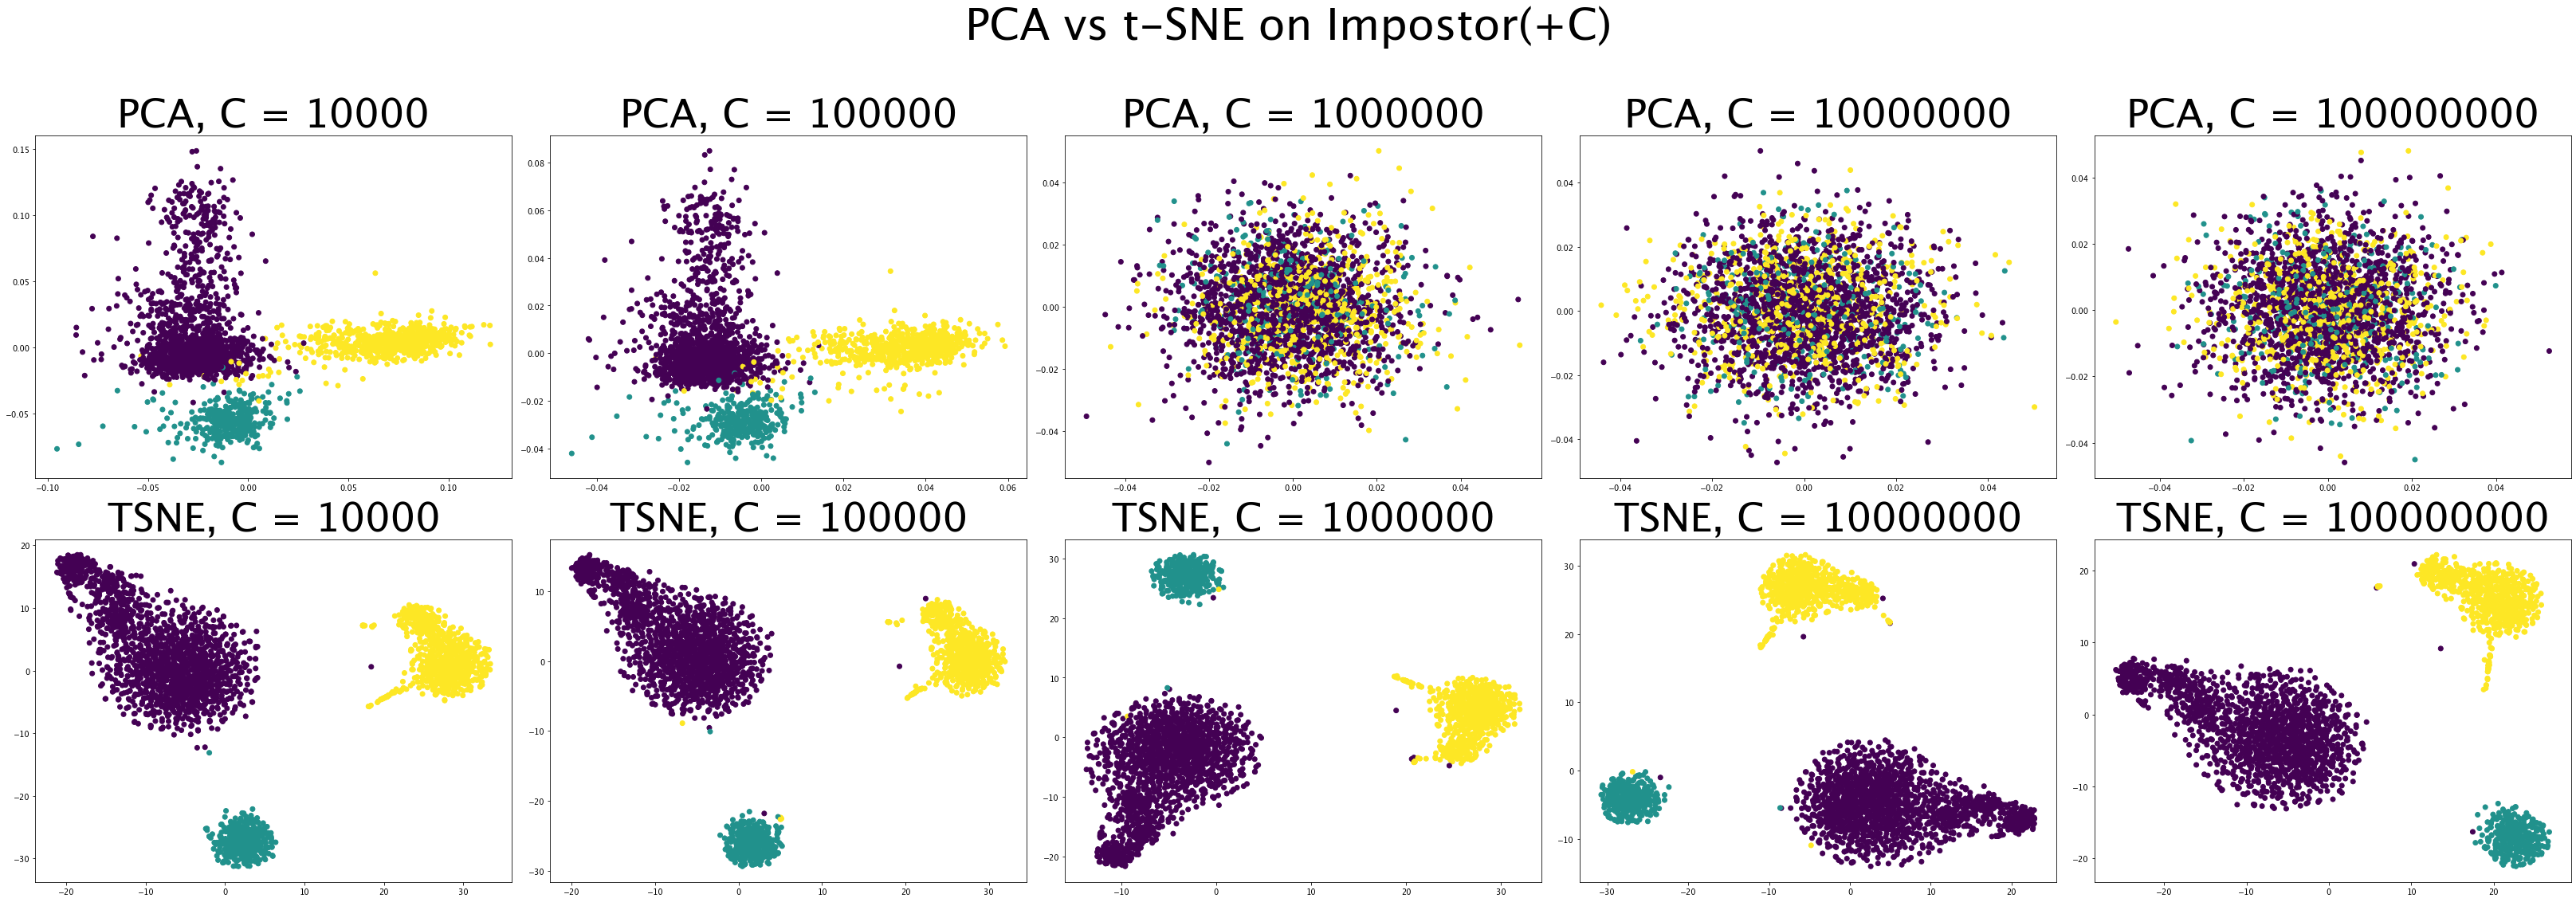

In [62]:
from tqdm import tqdm

fig, axs = plt.subplots(2, 5, figsize=(45,16))
for i in tqdm(range(5)):
    axs[0,i].set_title(f'PCA, C = {Cs[i]}', fontsize=50)
    axs[0,i].scatter(X_pcas[i][:,0], X_pcas[i][:,1], c=labels)

    axs[1,i].set_title(f'TSNE, C = {Cs[i]}', fontsize=50)
    axs[1,i].scatter(X_tsnes[i][:,0], X_tsnes[i][:,1], c=labels)


#plt.suptitle('PCA vs t-SNE on Impostor(+C)')
fig.suptitle('PCA vs t-SNE on Impostor(+C)\n', fontsize=55)
plt.tight_layout()
plt.savefig('visuals/1_single_cell/C_increasing.png', bbox_inches='tight')


In [63]:
## version of PCA where we apply some noise to the learned 
def pca(X, noise_scale = 0.7, n_components=2):
    # Step 1: center data
    X_centered = X - X.mean(axis=0)

    rng = np.random.default_rng(SEED)
    # Step 2: compute SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    noise = rng.normal(scale=noise_scale, size=Vt.shape)
    Vt = Vt + noise

    # Step 3: project data onto top principal components
    if n_components is None:
        n_components = X.shape[1]
    X_reduced = X_centered @ Vt[:n_components].T

    # Step 4: return
    return X_reduced 

100%|██████████| 5/5 [00:00<00:00, 24.46it/s]


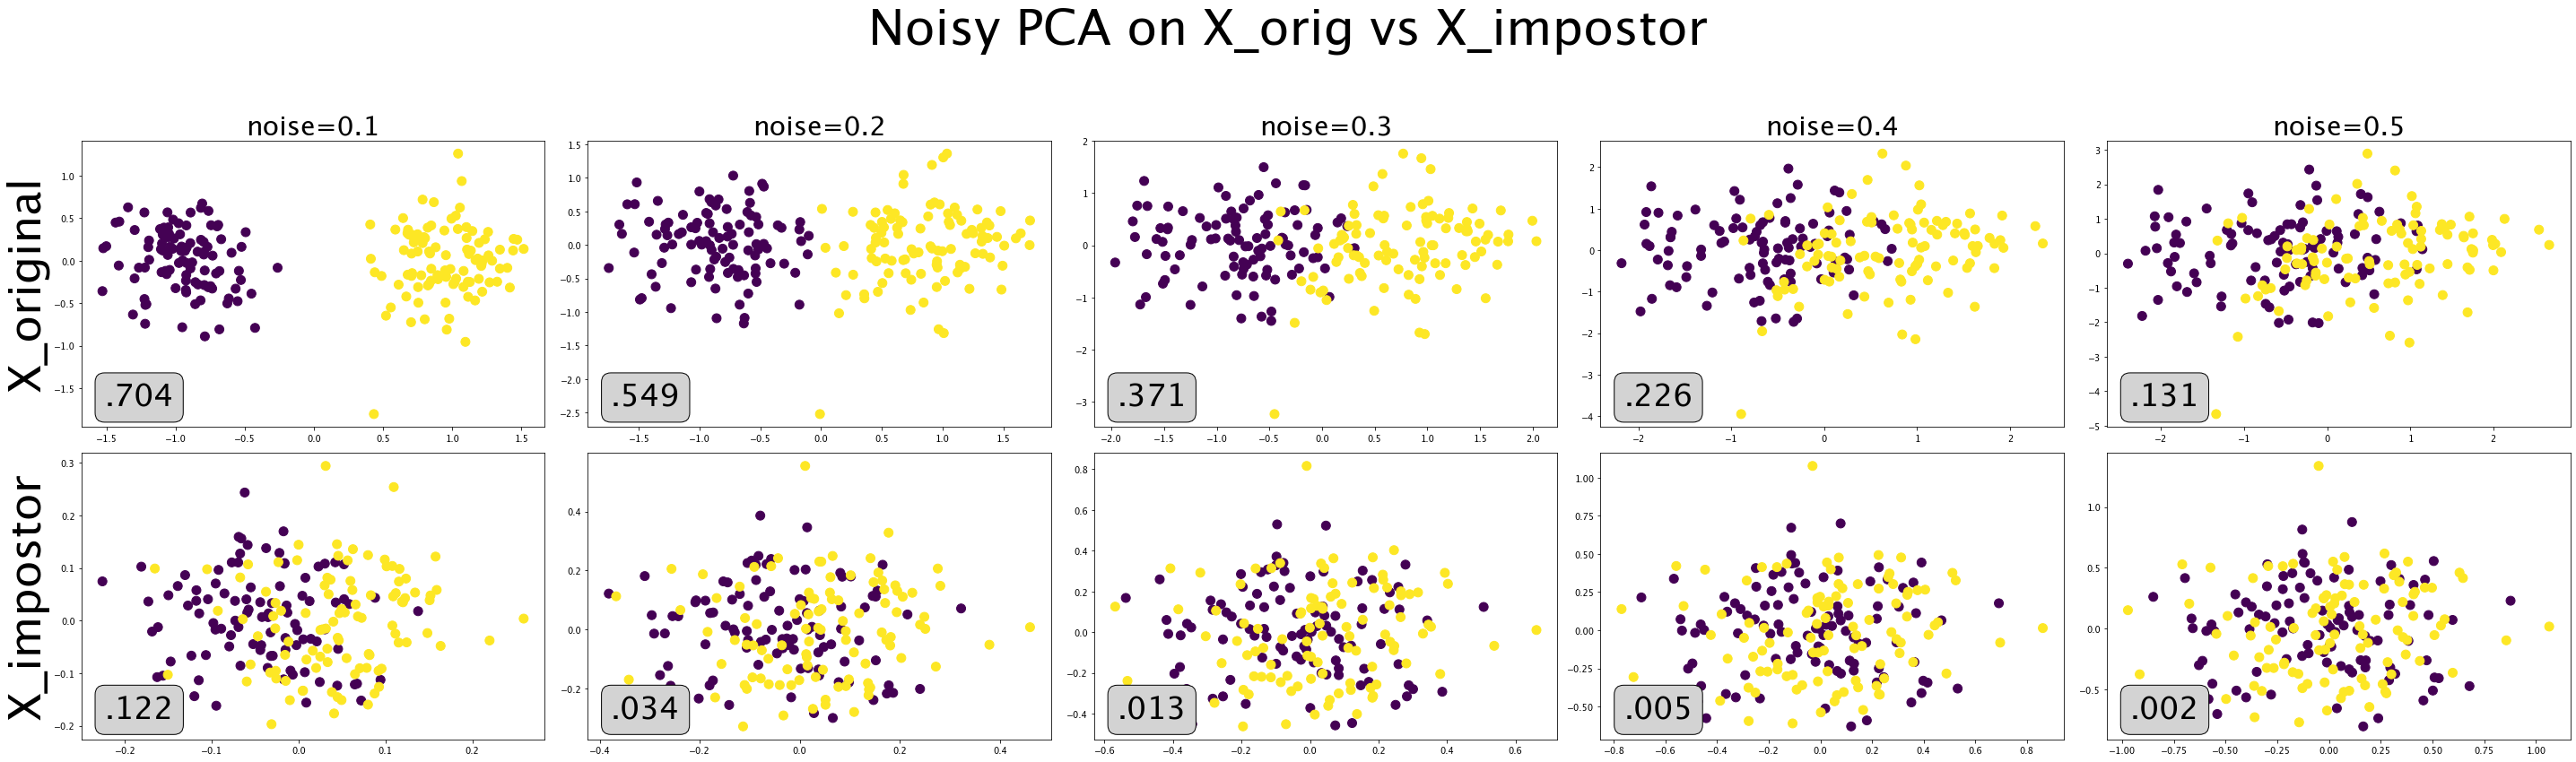

In [64]:


def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

# loading the 50-dimensional PCA of the PBMC3k dataset - our ground dataset
X = TwoGuassians(distance=2)
n = int(len(X))
C = 10000
D_squared = cdist(X,X, metric='sqeuclidean')
D_squared /= np.max(D_squared)
D_squared_impostor = D_squared + C*(np.ones((n,n)) - np.eye(n)) 
D_squared_impostor /= np.max(D_squared_impostor)
H = np.eye(n) - np.ones((n,n)) / n
X_impostor = KernelPCA(n_components=n-1, kernel='precomputed', random_state=SEED).fit_transform( - H @ D_squared_impostor @ H / 2.0 )

y=[0]*100 + [1]*100
noise_scales = [0.1*(i+1) for i in range(5)]
fig, axs = plt.subplots(2, len(noise_scales), figsize=(40,12))
for i in tqdm(range(len(noise_scales))):
    n = noise_scales[i]
    X_pca = pca(X, noise_scale=n)
    X_pca_impostor = pca(X_impostor, noise_scale=n)

    axs[0, i].set_title(f'noise={n:.1f}', fontsize=30)
    axs[0, i].scatter(X_pca[:,0], X_pca[:,1], c=y, s=100)
    ss0 = silhouette_score(X_pca, y)
    axs[0,i].text(0.05, 0.05, f"{ss0:.3f}".lstrip("0"),transform=axs[0,i].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=35, ha="left", va="bottom")


    axs[1, i].scatter(X_pca_impostor[:,0], X_pca_impostor[:,1], c=y, s=100)
    ss_imp = silhouette_score(X_pca_impostor, y)
    axs[1,i].text(0.05, 0.05, f"{ss_imp:.3f}".lstrip("0"),transform=axs[1,i].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=35, ha="left", va="bottom")

axs[0,0].set_ylabel('X_original', fontsize=50)
axs[1,0].set_ylabel('X_impostor', fontsize=50)

fig.suptitle('Noisy PCA on X_orig vs X_impostor\n', fontsize=55)
plt.tight_layout()
plt.savefig('visuals/1_single_cell/pca_vs_noise_orig_vs_impostor.png')


This last bit illustrates how PCA becomes more unstable on the impostor dataset.